In [6]:
from _helper_basics_ import *
%reload_ext autoreload

# UNet 
for Speech Enhancement (Spectrogram)

In [1]:
import sys
## To get helper functions from another folder
# sys.path.insert(0, '../') # if _helper_basics_ is in previous folder
now_i_am_at = 'home' # home dso test
if now_i_am_at=='home': sys.path.insert(0, 'E:/Leonard HDD/Dropbox/DSO/Tasks/')
elif now_i_am_at=='dso': sys.path.insert(0, 'D:/Dropbox/DSO/Tasks')

from _helper_basics_ import *

%matplotlib inline
plt.rcParams['savefig.dpi'] = 100

%load_ext autoreload
%autoreload 2

print('keras',      keras.__version__)
print('tensorflow', tf.__version__)

Using TensorFlow backend.


keras 2.0.8
tensorflow 1.3.0


# Data

In [2]:
sr = 16000

# Setup & Training

End-to-end UNet for enhancement.

filt_incept = [[], [16, 8, 8, 16, 16], 
                   [32, 16, 16, 32, 32],
                   [32, 16, 16, 32, 32], 
                   [16, 8, 8, 16, 16]]
filt_incept = [[], [32, 16, 16, 32, 32], 
                   [32, 16, 16, 32, 32],
                   [32, 16, 16, 32, 32], 
                   [32, 16, 16, 32, 32]]

In [3]:
def build_UNet_list(input_shape,  conv_activ, filt_incept, num_encoders=2, reg_l1=0., reg_l2=0.):
    ######################### Build Architecture ##########################
    Inp = Input(shape=input_shape, name='Input'); ell=0
    ## Initial Conv Layer
    x = conv2dBlock(Inp, filters=filt_incept[ell][0], name='0'); ell+=1
    ## Encoder
    Encoder_list = []
    Encoder_list.append(Inception_block(x, filt_incept[ell], ell=ell)); ell+=1
    for idx in range(1,num_encoders):
        Encoder_list.append(Inception_block(Encoder_list[idx-1], filt_incept[ell], ell=ell)); ell+=1

    ## Code
    Code = conv2dBlock(Encoder_list[-1], filters=filt_incept[ell][0], name='CODE'); ell+=1

    ## Decoder
    Decoder_list,UNet_list = [],[]
    Decoder_list.append( Inception_block(Code, filt_incept[ell], ell=ell) )
    UNet_list.append( concatenate([Decoder_list[-1],Encoder_list[-1]], name=str(ell)+'_UNet') ); ell+=1
    for idx in range(1,num_encoders):
        Decoder_list.append(Inception_block(UNet_list[idx-1], filt_incept[ell], ell=ell)); 
        UNet_list.append( concatenate([Decoder_list[-1],Encoder_list[-idx-1]], name=str(ell)+'_UNet') ); ell+=1

    ## Final Conv Layer
    # relu activation for spectrogram prediction. 
    x = conv2dBlock(UNet_list[-1], conv_activ='relu', filters=filt_incept[ell][0], name=str(ell)); ell+=1
    train_model = Model(Inp, x)
    return train_model

In [80]:
########################## Printing information ###########################
num_encoders = 4
Inception_filters = [64, 32, 16, 64, 32]
filt_incept = [[64]]+[Inception_filters]*num_encoders+[[64, 32, 32, 64, 64]]+[Inception_filters]*num_encoders+[[1]]
build_UNet_list(input_shape=(num_freq,num_time,num_channel), conv_activ='selu', 
                filt_incept=filt_incept,  num_encoders=num_encoders,
                reg_l1=0., reg_l2=0.).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 129, 128, 1)   0                                            
____________________________________________________________________________________________________
0_Conv2D (Conv2D)                (None, 129, 128, 64)  640         Input[0][0]                      
____________________________________________________________________________________________________
1_1b_Conv2D (Conv2D)             (None, 129, 128, 32)  2080        0_Conv2D[0][0]                   
____________________________________________________________________________________________________
1_1c_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
___________________________________________________________________________________________

In [88]:
num_encoders = 10
Inception_filters = [16, 16, 16, 32, 16]
filt_incept = [[64]]+[Inception_filters]*num_encoders+[[64, 32, 32, 64, 64]]+[Inception_filters]*num_encoders+[[1]]
build_UNet_list(input_shape=(num_freq,num_time,num_channel), conv_activ='selu', 
                filt_incept=filt_incept,  num_encoders=num_encoders,
                reg_l1=0., reg_l2=0.).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 129, 128, 1)   0                                            
____________________________________________________________________________________________________
0_Conv2D (Conv2D)                (None, 129, 128, 64)  640         Input[0][0]                      
____________________________________________________________________________________________________
1_1b_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
____________________________________________________________________________________________________
1_1c_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
___________________________________________________________________________________________

In [4]:
num_freq    = 129
num_time    = 128
num_channel = 1
######################## Training Parameters ###############################
decay = 0;          	print('decay',decay)
steps_per_epoch = 500;	print('steps_per_epoch',steps_per_epoch)
epochs = 150;			print('epochs',epochs)
batch_size = 8;   		print('batch_size',batch_size)

decay 0
steps_per_epoch 500
epochs 150
batch_size 8


In [5]:
## Original wavfiles
data_dir = 'E:/Leonard HDD/Dropbox/Speech Audio Text/3) Dataset/Reverb_2'
noisy_dir = os.path.join(data_dir, 'noisy_trainset_28spk_wav')
clean_dir = os.path.join(data_dir, 'clean_trainset_28spk_wav')
print(noisy_dir)
print(clean_dir)

## Saving
pwd = 'E:/Leonard HDD/Dropbox/DSO/Tasks/Dereverberation'
save_data_dir = os.path.join(pwd, 'Reverb_Data_28spk_wav')
Noise_Mag_dir = os.path.join(save_data_dir, 'Noise_Mag')
Noise_Pha_dir = os.path.join(save_data_dir, 'Noise_Pha')
Clean_Mag_dir = os.path.join(save_data_dir, 'Clean_Mag')
Clean_Pha_dir = os.path.join(save_data_dir, 'Clean_Pha')
print('save_data_dir',save_data_dir)
print('Noise_Mag_dir',Noise_Mag_dir)
print('Noise_Pha_dir',Noise_Pha_dir)
print('Clean_Mag_dir',Clean_Mag_dir)
print('Clean_Pha_dir',Clean_Pha_dir)

noise_files_list = []
for noise_wav in glob.glob( os.path.join(noisy_dir, '*.wav') ):
    noise_wav_term = noise_wav[len(noisy_dir)+1:len(noise_wav)-4]
    noise_files_list.append(noise_wav_term)
len(noise_files_list)

E:/Leonard HDD/Dropbox/Speech Audio Text/3) Dataset/Reverb_2\noisy_trainset_28spk_wav
E:/Leonard HDD/Dropbox/Speech Audio Text/3) Dataset/Reverb_2\clean_trainset_28spk_wav
save_data_dir E:/Leonard HDD/Dropbox/DSO/Tasks/Dereverberation\Reverb_Data_28spk_wav
Noise_Mag_dir E:/Leonard HDD/Dropbox/DSO/Tasks/Dereverberation\Reverb_Data_28spk_wav\Noise_Mag
Noise_Pha_dir E:/Leonard HDD/Dropbox/DSO/Tasks/Dereverberation\Reverb_Data_28spk_wav\Noise_Pha
Clean_Mag_dir E:/Leonard HDD/Dropbox/DSO/Tasks/Dereverberation\Reverb_Data_28spk_wav\Clean_Mag
Clean_Pha_dir E:/Leonard HDD/Dropbox/DSO/Tasks/Dereverberation\Reverb_Data_28spk_wav\Clean_Pha


11572

#### This is loading the cheating way. Take 1 spectrogram and have 8 crops from it.
##### 10 times faster than the proper way

In [6]:
def get_XY_batch(batch_size):
    ## Loading STFT from disk
    ## Load noisy spectrogram
    while 1:
        np.random.shuffle(noise_files_list)
        noise_wav_term = noise_files_list[0]
        clean_wav_term = noise_wav_term
        try: x1_mag = dump_load_pickle(os.path.join(Noise_Mag_dir,noise_wav_term+'_mag'), 'load')
        except FileNotFoundError: continue
        if x1_mag.shape[1] < num_time: continue
        ## Load Clean spectrogram
        x2_mag = dump_load_pickle(os.path.join(Clean_Mag_dir,clean_wav_term+'_mag'), 'load')
        break

    ## Choose a random num_time crop of the spectrogram.
    count = 0
    x_batch,y_batch = [],[]
    for _ in range(batch_size):
        start_idx = np.random.randint(0, x1_mag.shape[1]-num_time-1)
        x_batch.append(x1_mag[:,start_idx:start_idx+num_time].reshape(num_freq,num_time,num_channel))
        y_batch.append(x2_mag[:,start_idx:start_idx+num_time].reshape(num_freq,num_time,num_channel))
        count += 1
        if count == batch_size: break
    x_batch = np.asarray(x_batch)
    y_batch = np.asarray(y_batch)
    return x_batch, y_batch
def infinite_Gen(batch_size):
    while 1:
        x_batch, y_batch = get_XY_batch(batch_size)
        yield x_batch, y_batch

In [67]:
## Time taken to read from disk for 1 Epoch
start_time = time.time()
for _ in range(1000):
    get_XY_batch(batch_size)
time.time() - start_time

# Extrapolate to 11572

39.65008568763733

#### This is proper way. Take 8 spectrogram and have 1 crop from it.
##### But is extremely slow

In [61]:
# def get_XY_batch(batch_size):
#     ## Loading STFT from disk
#     count = 0
#     np.random.shuffle(noise_files_list)
#     x_batch,y_batch = [],[]
#     for noise_wav_term in noise_files_list:
#         clean_wav_term = noise_wav_term
#         ## Load noisy spectrogram
#         try: x1_mag = dump_load_pickle(os.path.join(Noise_Mag_dir,noise_wav_term+'_mag'), 'load')
#         except FileNotFoundError: continue
#         if x1_mag.shape[1] < num_time: continue
#         ## Load Clean spectrogram
#         x2_mag = dump_load_pickle(os.path.join(Clean_Mag_dir,clean_wav_term+'_mag'), 'load')

#         ## Choose a random num_time crop of the spectrogram.
#         start_idx = np.random.randint(0, x1_mag.shape[1]-num_time-1)
#         x1_mag = x1_mag[:,start_idx:start_idx+num_time].reshape(num_freq,num_time,num_channel)
#         x2_mag = x2_mag[:,start_idx:start_idx+num_time].reshape(num_freq,num_time,num_channel)
#         x_batch.append(x1_mag)
#         y_batch.append(x2_mag)
#         count += 1
#         if count == batch_size: break
#     x_batch = np.asarray(x_batch)
#     y_batch = np.asarray(y_batch)
#     return x_batch, y_batch
# def infinite_Gen(batch_size):
#     while 1:
#         x_batch, y_batch = get_XY_batch(batch_size)
#         yield x_batch, y_batch

# ## Time taken to read from disk for 1 Epoch
# start_time = time.time()
# for _ in range(1000):
#     get_XY_batch(batch_size)
# time.time() - start_time

# # Extrapolate to 11572

394.4421308040619

# V3 : UNet
10 encoders + 1 + 10 decoders
Inception_filters = [16, 16, 16, 32, 16]

In [7]:
Archi_dir = "v3/"
Weights_path = Archi_dir+"Logs/"
Ckpt_Mod_Weights_fold = Archi_dir+"Checkpoint_Model_Weights/"
plot_path_dir = Archi_dir+'Plots/'
if not os.path.exists(Archi_dir): os.mkdir(Archi_dir)
if not os.path.exists(Weights_path): os.mkdir(Weights_path)
if not os.path.exists(Ckpt_Mod_Weights_fold): os.mkdir(Ckpt_Mod_Weights_fold)
if not os.path.exists(plot_path_dir): os.mkdir(plot_path_dir)

#### Initial training : train_model_v3_1

In [10]:
num_encoders = 5
Inception_filters = [16, 16, 16, 32, 16]
filt_incept = [[64]]+[Inception_filters]*num_encoders+[[64, 32, 32, 64, 64]]+[Inception_filters]*num_encoders+[[1]]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 129, 128, 1)   0                                            
____________________________________________________________________________________________________
0_Conv2D (Conv2D)                (None, 129, 128, 64)  640         Input[0][0]                      
____________________________________________________________________________________________________
1_1b_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
____________________________________________________________________________________________________
1_1c_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
___________________________________________________________________________________________

103/500 [=====>........................] - ETA: 664s - loss: 0.1091

KeyboardInterrupt


In [12]:
num_encoders = 4
Inception_filters = [16, 16, 16, 32, 16]
filt_incept = [[64]]+[Inception_filters]*num_encoders+[[64, 32, 32, 64, 64]]+[Inception_filters]*num_encoders+[[1]]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 129, 128, 1)   0                                            
____________________________________________________________________________________________________
0_Conv2D (Conv2D)                (None, 129, 128, 64)  640         Input[0][0]                      
____________________________________________________________________________________________________
1_1b_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
____________________________________________________________________________________________________
1_1c_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
___________________________________________________________________________________________

 12/500 [..............................] - ETA: 822s - loss: 0.2307

KeyboardInterrupt


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 129, 128, 1)   0                                            
____________________________________________________________________________________________________
0_Conv2D (Conv2D)                (None, 129, 128, 64)  640         Input[0][0]                      
____________________________________________________________________________________________________
1_1b_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
____________________________________________________________________________________________________
1_1c_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
___________________________________________________________________________________________

500/500 [==============================] - 478s - loss: 0.0941   
Epoch 3/150
500/500 [==============================] - 476s - loss: 0.0565   
Epoch 4/150
500/500 [==============================] - 475s - loss: 0.0526   
Epoch 5/150
500/500 [==============================] - 474s - loss: 0.0570   
Epoch 6/150
500/500 [==============================] - 473s - loss: 0.0569   
Epoch 7/150
500/500 [==============================] - 474s - loss: 0.0431   
Epoch 8/150
500/500 [==============================] - 473s - loss: 0.0439   
Epoch 9/150
500/500 [==============================] - 473s - loss: 0.0397   
Epoch 10/150
500/500 [==============================] - 472s - loss: 0.0469   
Epoch 11/150
500/500 [==============================] - 473s - loss: 0.0422   
Epoch 12/150
500/500 [==============================] - 474s - loss: 0.0404   
Epoch 13/150
500/500 [==============================] - 473s - loss: 0.0449   
Epoch 14/150
500/500 [==============================] - 472s - loss: 0.0

500/500 [==============================] - 473s - loss: 0.0326   
Epoch 35/150
500/500 [==============================] - 474s - loss: 0.0350   
Epoch 36/150
500/500 [==============================] - 473s - loss: 0.0320   
Epoch 37/150
500/500 [==============================] - 466s - loss: 0.2528   
Epoch 38/150
499/500 [============================>.] - ETA: 0s - loss: 0.4640
Epoch 00037: reducing learning rate to 0.00020000000949949026.
Epoch 00037: saving model to v3/Checkpoint_Model_Weights/v3_1/weights_LR-1.00e-03_Epoch-0037_L-0.46.hdf5
500/500 [==============================] - 459s - loss: 0.4644   
Epoch 39/150
500/500 [==============================] - 459s - loss: 0.4796   
Epoch 40/150
500/500 [==============================] - 458s - loss: 0.4581   
Epoch 41/150
500/500 [==============================] - 459s - loss: 0.4700   
Epoch 42/150
500/500 [==============================] - 458s - loss: 0.4583   
Epoch 43/150
500/500 [==============================] - 459s - loss:

500/500 [==============================] - 459s - loss: 0.4530   
Epoch 68/150
499/500 [============================>.] - ETA: 0s - loss: 0.4665
Epoch 00067: reducing learning rate to 8.000000525498762e-06.
Epoch 00067: saving model to v3/Checkpoint_Model_Weights/v3_1/weights_LR-1.00e-03_Epoch-0067_L-0.47.hdf5
500/500 [==============================] - 459s - loss: 0.4666   
Epoch 69/150
500/500 [==============================] - 459s - loss: 0.4763   
Epoch 70/150
500/500 [==============================] - 459s - loss: 0.4493   
Epoch 71/150
500/500 [==============================] - 454s - loss: 0.4521   
Epoch 72/150
500/500 [==============================] - 442s - loss: 0.4563   
Epoch 73/150
500/500 [==============================] - 442s - loss: 0.4595   
Epoch 74/150
500/500 [==============================] - 442s - loss: 0.4672   
Epoch 75/150
500/500 [==============================] - 441s - loss: 0.4319   
Epoch 76/150
500/500 [==============================] - 442s - loss: 

500/500 [==============================] - 442s - loss: 0.4472   
Epoch 100/150
500/500 [==============================] - 442s - loss: 0.4741   
Epoch 101/150
500/500 [==============================] - 441s - loss: 0.4387   
Epoch 102/150
500/500 [==============================] - 442s - loss: 0.4531   
Epoch 103/150
500/500 [==============================] - 442s - loss: 0.4681   
Epoch 104/150
500/500 [==============================] - 442s - loss: 0.4687   
Epoch 105/150
500/500 [==============================] - 442s - loss: 0.4793   
Epoch 106/150
500/500 [==============================] - 442s - loss: 0.4642   
Epoch 107/150
500/500 [==============================] - 442s - loss: 0.4621   
Epoch 108/150
500/500 [==============================] - 442s - loss: 0.4864   
Epoch 109/150
500/500 [==============================] - 441s - loss: 0.4837   
Epoch 110/150
500/500 [==============================] - 442s - loss: 0.4705   
Epoch 111/150
500/500 [==============================]

500/500 [==============================] - 441s - loss: 0.4662   
Epoch 132/150
500/500 [==============================] - 442s - loss: 0.4620   
Epoch 133/150
500/500 [==============================] - 442s - loss: 0.4504   
Epoch 134/150
500/500 [==============================] - 441s - loss: 0.4629   
Epoch 135/150
500/500 [==============================] - 441s - loss: 0.4682   
Epoch 136/150
500/500 [==============================] - 442s - loss: 0.4747   
Epoch 137/150
500/500 [==============================] - 441s - loss: 0.4813   
Epoch 138/150
500/500 [==============================] - 441s - loss: 0.4852   
Epoch 139/150
500/500 [==============================] - 442s - loss: 0.4780   
Epoch 140/150
500/500 [==============================] - 442s - loss: 0.4684   
Epoch 141/150
500/500 [==============================] - 441s - loss: 0.4643   
Epoch 142/150
500/500 [==============================] - 442s - loss: 0.4611   
Epoch 143/150
500/500 [==============================]

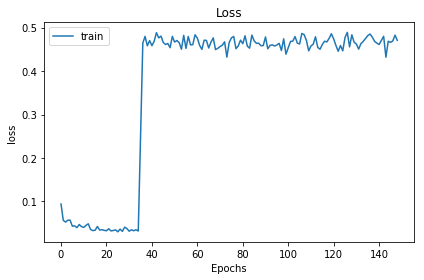

In [16]:
num_encoders = 3
Inception_filters = [16, 16, 16, 32, 16]
filt_incept = [[64]]+[Inception_filters]*num_encoders+[[16, 16, 16, 32, 32]]+[Inception_filters]*num_encoders+[[1]]
train_model_v3_1 = build_UNet_list(input_shape=(num_freq,num_time,num_channel), conv_activ='selu', 
                filt_incept=filt_incept,  num_encoders=num_encoders,
                reg_l1=0., reg_l2=0.)
train_model_v3_1.summary()
######################## Training Parameters ###############################
learning_rate = 1e-3;   print('learning_rate',learning_rate)
adam_opt = Adam(lr=learning_rate, decay=decay)
train_model_v3_1.compile(loss='mse' ,optimizer=adam_opt)
######################## Checkpoints ###############################
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=1e-6, cooldown=5, epsilon=1e-05, verbose=1)
CkptFold_det = ['{:.2e}'.format(learning_rate), Ckpt_Mod_Weights_fold, 'v3_1/']
#              [str_int,                       Ckpt_Mod_Weights_Fold, LR_Fold]
ModelCheckpoint_det = ['loss',     1,            False,              True,           1] 
#              [monitor_modes, verbose_ckpt, save_best_only, save_weights_only, period]
ckpt = ckpt_saving(CkptFold_det, ModelCheckpoint_det, save_all=True)
csv_log = CSVLogger(Weights_path+'v3_1_Trg_log_{:.2e}.txt'.format(learning_rate), '\t', append=False)
plot_path = plot_path_dir+'v3_1_{:.2e}.png'.format(learning_rate)
########################### Actual training ##################################
try:
    history_v3_1 = train_model_v3_1.fit_generator( infinite_Gen(batch_size), 
                                               steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                                               callbacks=[reduce_lr, csv_log, ckpt], 
                                               validation_data=None, validation_steps=None, 
                                               class_weight=None, max_queue_size=10, workers=1, 
                                               use_multiprocessing=False, shuffle=True, initial_epoch=1)
    plot_loss(history_v3_1, metric_list=['loss'], title='Loss',  plot_path=plot_path)
except KeyboardInterrupt:
    print('\n\nKeyboardInterrupt')

In [17]:
save_or_load = 'save'
model_path = Weights_path+Archi_dir[:-1]+"_model_v3_1.json"
weights_path = Weights_path+Archi_dir[:-1]+"_weights_v3_1.h5"
if save_or_load == 'save':
    save_model(train_model_v3_1, model_path, weights_path)
elif save_or_load == 'load':
    train_model_v3_1 = load_model(model_path, 'path', weights_path, 'final')
    train_model_v3_1.summary()

Saved model : v3/Logs/v3_model_v3_1.json
Saved weights : v3/Logs/v3_weights_v3_1.h5


#### train_model_v3_2
Don't know why first one failed. Try again with tighter (16 to 8) n_1c_Conv2D but with more (16 to 32) n_5_Conv2D

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 129, 128, 1)   0                                            
____________________________________________________________________________________________________
0_Conv2D (Conv2D)                (None, 129, 128, 64)  640         Input[0][0]                      
____________________________________________________________________________________________________
1_1b_Conv2D (Conv2D)             (None, 129, 128, 16)  1040        0_Conv2D[0][0]                   
____________________________________________________________________________________________________
1_1c_Conv2D (Conv2D)             (None, 129, 128, 8)   520         0_Conv2D[0][0]                   
___________________________________________________________________________________________

500/500 [==============================] - 521s - loss: 0.0803   
Epoch 3/150
500/500 [==============================] - 516s - loss: 0.0642   
Epoch 4/150
500/500 [==============================] - 515s - loss: 0.0618   
Epoch 5/150
500/500 [==============================] - 514s - loss: 0.0585   
Epoch 6/150
500/500 [==============================] - 514s - loss: 0.0557   
Epoch 7/150
500/500 [==============================] - 517s - loss: 0.0390   
Epoch 8/150
500/500 [==============================] - 515s - loss: 0.0540   
Epoch 9/150
500/500 [==============================] - 513s - loss: 0.0538   
Epoch 10/150
500/500 [==============================] - 514s - loss: 0.0495   
Epoch 11/150
500/500 [==============================] - 516s - loss: 0.0427   
Epoch 12/150
500/500 [==============================] - 515s - loss: 0.0417   
Epoch 13/150
500/500 [==============================] - 514s - loss: 0.0445   
Epoch 14/150
500/500 [==============================] - 515s - loss: 0.0

500/500 [==============================] - 502s - loss: 0.4502   
Epoch 35/150
500/500 [==============================] - 502s - loss: 0.4692   
Epoch 36/150
500/500 [==============================] - 502s - loss: 0.4709   
Epoch 37/150
500/500 [==============================] - 502s - loss: 0.4647   
Epoch 38/150
500/500 [==============================] - 502s - loss: 0.4676   
Epoch 39/150
500/500 [==============================] - 502s - loss: 0.4531   
Epoch 40/150
500/500 [==============================] - 502s - loss: 0.4625   
Epoch 41/150
500/500 [==============================] - 502s - loss: 0.4745   
Epoch 42/150
500/500 [==============================] - 502s - loss: 0.4643   
Epoch 43/150
500/500 [==============================] - 502s - loss: 0.4817   
Epoch 44/150
500/500 [==============================] - 502s - loss: 0.4559   
Epoch 45/150
500/500 [==============================] - 502s - loss: 0.4564   
Epoch 46/150
500/500 [==============================] - 502s - lo

500/500 [==============================] - 503s - loss: 0.4567   
Epoch 68/150
500/500 [==============================] - 503s - loss: 0.4648   
Epoch 69/150
500/500 [==============================] - 502s - loss: 0.4772   
Epoch 70/150
500/500 [==============================] - 503s - loss: 0.4701   
Epoch 71/150
500/500 [==============================] - 503s - loss: 0.4631   
Epoch 72/150
500/500 [==============================] - 503s - loss: 0.4870   
Epoch 73/150
500/500 [==============================] - 503s - loss: 0.4518   
Epoch 74/150
500/500 [==============================] - 503s - loss: 0.4737   
Epoch 75/150
500/500 [==============================] - 503s - loss: 0.4726   
Epoch 76/150
500/500 [==============================] - 503s - loss: 0.4627   
Epoch 77/150
500/500 [==============================] - 502s - loss: 0.4788   
Epoch 78/150
499/500 [============================>.] - ETA: 1s - loss: 0.4595
Epoch 00077: reducing learning rate to 1e-06.
Epoch 00077: saving

500/500 [==============================] - 503s - loss: 0.4406   
Epoch 100/150
500/500 [==============================] - 503s - loss: 0.4721   
Epoch 101/150
500/500 [==============================] - 503s - loss: 0.4539   
Epoch 102/150
500/500 [==============================] - 502s - loss: 0.4801   
Epoch 103/150
500/500 [==============================] - 503s - loss: 0.4771   
Epoch 104/150
500/500 [==============================] - 502s - loss: 0.4725   
Epoch 105/150
500/500 [==============================] - 503s - loss: 0.4541   
Epoch 106/150
500/500 [==============================] - 502s - loss: 0.4637   
Epoch 107/150
500/500 [==============================] - 502s - loss: 0.4628   
Epoch 108/150
500/500 [==============================] - 502s - loss: 0.4685   
Epoch 109/150
500/500 [==============================] - 502s - loss: 0.4514   
Epoch 110/150
500/500 [==============================] - 502s - loss: 0.4544   
Epoch 111/150
500/500 [==============================]

500/500 [==============================] - 503s - loss: 0.4618   
Epoch 133/150
500/500 [==============================] - 503s - loss: 0.4525   
Epoch 134/150
500/500 [==============================] - 503s - loss: 0.4533   
Epoch 135/150
500/500 [==============================] - 503s - loss: 0.4579   
Epoch 136/150
500/500 [==============================] - 503s - loss: 0.4563   
Epoch 137/150
500/500 [==============================] - 503s - loss: 0.4458   
Epoch 138/150
500/500 [==============================] - 503s - loss: 0.4594   
Epoch 139/150
500/500 [==============================] - 503s - loss: 0.4652   
Epoch 140/150
500/500 [==============================] - 503s - loss: 0.4593   
Epoch 141/150
500/500 [==============================] - 503s - loss: 0.4804   
Epoch 142/150
500/500 [==============================] - 503s - loss: 0.4610   
Epoch 143/150
500/500 [==============================] - 503s - loss: 0.4653   
Epoch 144/150
500/500 [==============================]

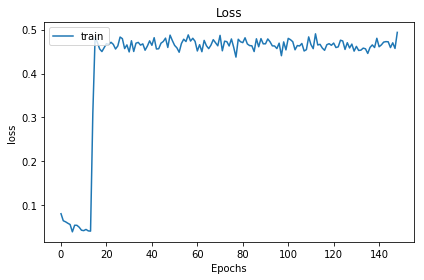

In [8]:
num_encoders = 3
Inception_filters = [16, 16, 8, 32, 32]
filt_incept = [[64]]+[Inception_filters]*num_encoders+[[16, 16, 16, 32, 32]]+[Inception_filters]*num_encoders+[[1]]
train_model_v3_2 = build_UNet_list(input_shape=(num_freq,num_time,num_channel), conv_activ='selu', 
                filt_incept=filt_incept,  num_encoders=num_encoders,
                reg_l1=0., reg_l2=0.)
train_model_v3_2.summary()
######################## Training Parameters ###############################
learning_rate = 1e-3;   print('learning_rate',learning_rate)
adam_opt = Adam(lr=learning_rate, decay=decay)
train_model_v3_2.compile(loss='mse' ,optimizer=adam_opt)
######################## Checkpoints ###############################
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=1e-6, cooldown=5, epsilon=1e-05, verbose=1)
CkptFold_det = ['{:.2e}'.format(learning_rate), Ckpt_Mod_Weights_fold, 'v3_2/']
#              [str_int,                       Ckpt_Mod_Weights_Fold, LR_Fold]
ModelCheckpoint_det = ['loss',     1,            False,              True,           1] 
#              [monitor_modes, verbose_ckpt, save_best_only, save_weights_only, period]
ckpt = ckpt_saving(CkptFold_det, ModelCheckpoint_det, save_all=True)
csv_log = CSVLogger(Weights_path+'v3_2_Trg_log_{:.2e}.txt'.format(learning_rate), '\t', append=False)
plot_path = plot_path_dir+'v3_2_{:.2e}.png'.format(learning_rate)
########################### Actual training ##################################
try:
    history_v3_2 = train_model_v3_2.fit_generator( infinite_Gen(batch_size), 
                                               steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                                               callbacks=[reduce_lr, csv_log, ckpt], 
                                               validation_data=None, validation_steps=None, 
                                               class_weight=None, max_queue_size=10, workers=1, 
                                               use_multiprocessing=False, shuffle=True, initial_epoch=1)
    plot_loss(history_v3_2, metric_list=['loss'], title='Loss',  plot_path=plot_path)
except KeyboardInterrupt:
    print('\n\nKeyboardInterrupt')

In [9]:
save_or_load = 'save'
model_path = Weights_path+Archi_dir[:-1]+"_model_v3_2.json"
weights_path = Weights_path+Archi_dir[:-1]+"_weights_v3_2.h5"
if save_or_load == 'save':
    save_model(train_model_v3_2, model_path, weights_path)
elif save_or_load == 'load':
    train_model_v3_2 = load_model(model_path, 'path', weights_path, 'final')
    train_model_v3_2.summary()

Saved model : v3/Logs/v3_model_v3_2.json
Saved weights : v3/Logs/v3_weights_v3_2.h5


# Prediction & Analysis on a cropped region

In [108]:
np.random.shuffle(noise_files_list)
wav_term = noise_files_list[0]
try: 
    x1_mag = dump_load_pickle(os.path.join(Noise_Mag_dir,wav_term+'_mag'), 'load')
    x1_pha = dump_load_pickle(os.path.join(Noise_Pha_dir,wav_term+'_pha'), 'load')
    x2_mag = dump_load_pickle(os.path.join(Clean_Mag_dir,wav_term+'_mag'), 'load')
    x2_pha = dump_load_pickle(os.path.join(Clean_Pha_dir,wav_term+'_pha'), 'load')
    print('x1_mag',x1_mag.shape)
    print('x1_pha',x1_pha.shape)
    print('x2_mag',x2_mag.shape)
    print('x2_pha',x2_pha.shape)

    ## Crop regions
    start_idx = np.random.randint(0, x1_mag.shape[1]-num_time-1)
    print('\n(start_idx,start_idx+num_time)', (start_idx,start_idx+num_time))
    x_batch_mag = x1_mag[:,start_idx:start_idx+num_time].reshape(num_freq,num_time)
    y_batch_mag = x2_mag[:,start_idx:start_idx+num_time].reshape(num_freq,num_time)
    x_batch_pha = x1_pha[:,start_idx:start_idx+num_time].reshape(num_freq,num_time)
    y_batch_pha = x2_pha[:,start_idx:start_idx+num_time].reshape(num_freq,num_time)
    # x_S = S_Mag*np.exp(1.j*S_Phase)

    ## Enhancement of spectrogram
    x_hat_mag = train_model_v1_1.predict(x_batch_mag.reshape(1,num_freq,num_time,num_channel))[0,:,:,0]
    print('\nx_hat_mag',x_hat_mag.shape)
    x1, sr = librosa.load( os.path.join(noisy_dir, noise_wav_term+'.wav'), sr=16000)
    x_istft = spect2wav(None, x_batch_mag.reshape(num_freq,num_time), x_batch_pha, [None,None], mode='Spect')
    x_istft_1 = spect2wav(None, x_hat_mag, x_batch_pha, [None,None], mode='Spect')
    x_istft_2 = spect2wav(None, x_hat_mag, y_batch_pha, [None,None], mode='Spect')
    y_istft = spect2wav(None, y_batch_mag, y_batch_pha, [None,None], mode='Spect')
    
except FileNotFoundError: print('no such file, try again')

x1_mag (129, 375)
x1_pha (129, 375)
x2_mag (129, 375)
x2_pha (129, 375)

(start_idx,start_idx+num_time) (235, 363)

x_hat_mag (129, 128)


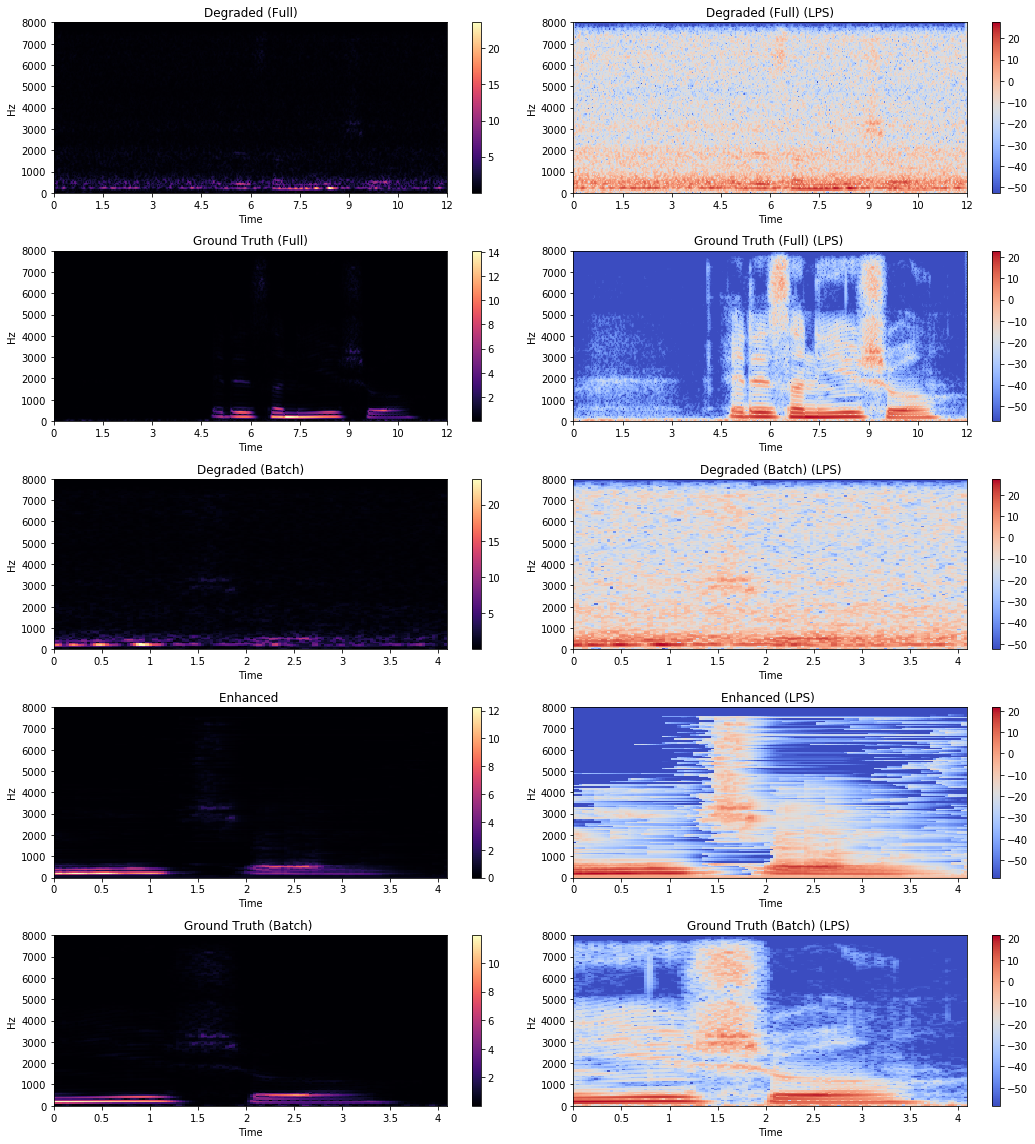

In [109]:
## Spectrogram plots
plt.figure(figsize=(15,16))
k=5;col=2;l=1; colorbar=1 #None
plt.subplot(k,col,l); l+=1; display_audio(x1_mag, 'Degraded (Full)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(librosa.amplitude_to_db(x1_mag), 'Degraded (Full) (LPS)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(x2_mag, 'Ground Truth (Full)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(librosa.amplitude_to_db(x2_mag), 'Ground Truth (Full) (LPS) ', sr, 'spec', colorbar=colorbar)

plt.subplot(k,col,l); l+=1; display_audio(x_batch_mag, 'Degraded (Batch)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(librosa.amplitude_to_db(x_batch_mag), 'Degraded (Batch) (LPS)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(x_hat_mag, 'Enhanced ', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(librosa.amplitude_to_db(x_hat_mag), 'Enhanced (LPS) ', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(y_batch_mag, 'Ground Truth (Batch) ', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(librosa.amplitude_to_db(y_batch_mag), 'Ground Truth (Batch) (LPS) ', sr, 'spec', colorbar=colorbar)
plt.tight_layout()

In [110]:
print('## Input (Full)'); display_audio(x1, None, sr, 'audio')
print('## Input (Batch)'); display_audio(x_istft, None, sr, 'audio')
print('## Enhanced (with noisy phase)'); display_audio(x_istft_1, None, sr, 'audio')
print('## Enhanced (with truth phase)'); display_audio(x_istft_2, None, sr, 'audio')
print('## Ground Truth'); display_audio(y_istft, None, sr, 'audio')

## Input (Full)


## Input (Batch)


## Enhanced (with noisy phase)


## Enhanced (with truth phase)


## Ground Truth


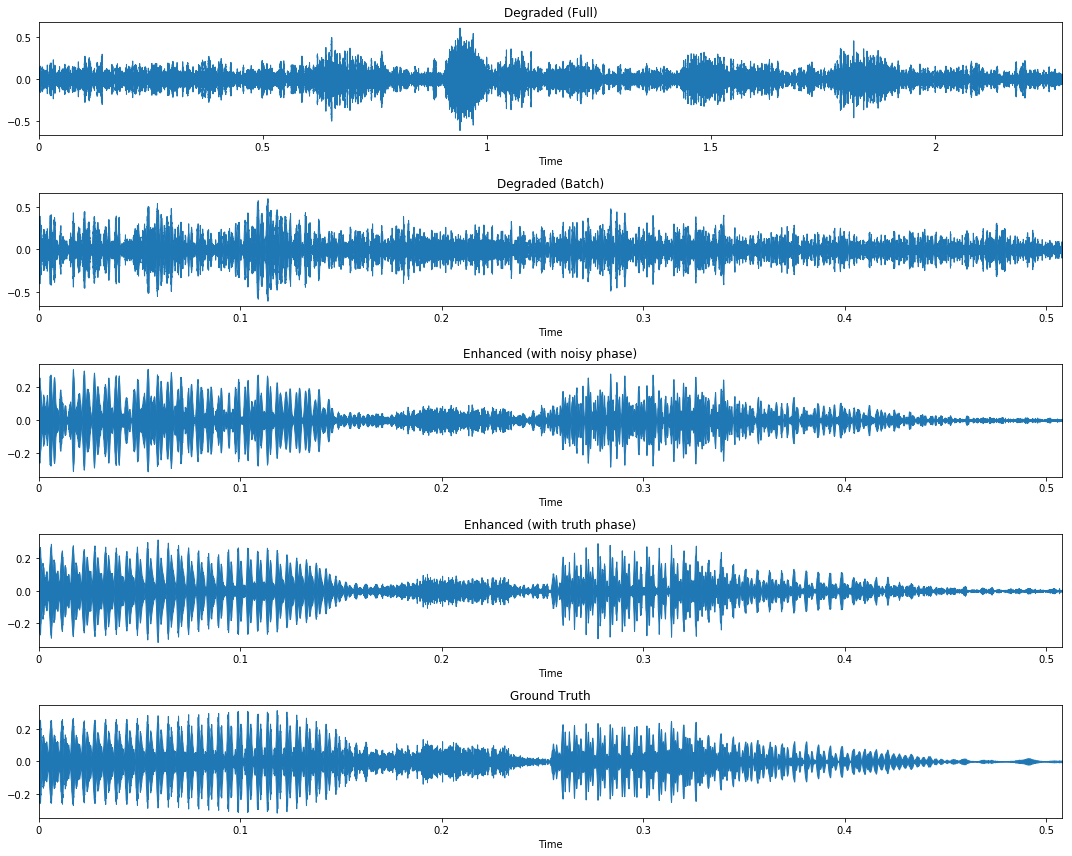

In [111]:
## Waveform Plots
plt.figure(figsize=(15,12))
k=5;col=1;l=1; colorbar=None
plt.subplot(k,col,l); l+=1; display_audio(x1, 'Degraded (Full)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(x_istft, 'Degraded (Batch)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(x_istft_1, 'Enhanced (with noisy phase)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(x_istft_2, 'Enhanced (with truth phase)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(y_istft, 'Ground Truth', sr, 'wave')
plt.tight_layout()

## Overlapping ground truth and enhanced to compare effectiveness of using real phase

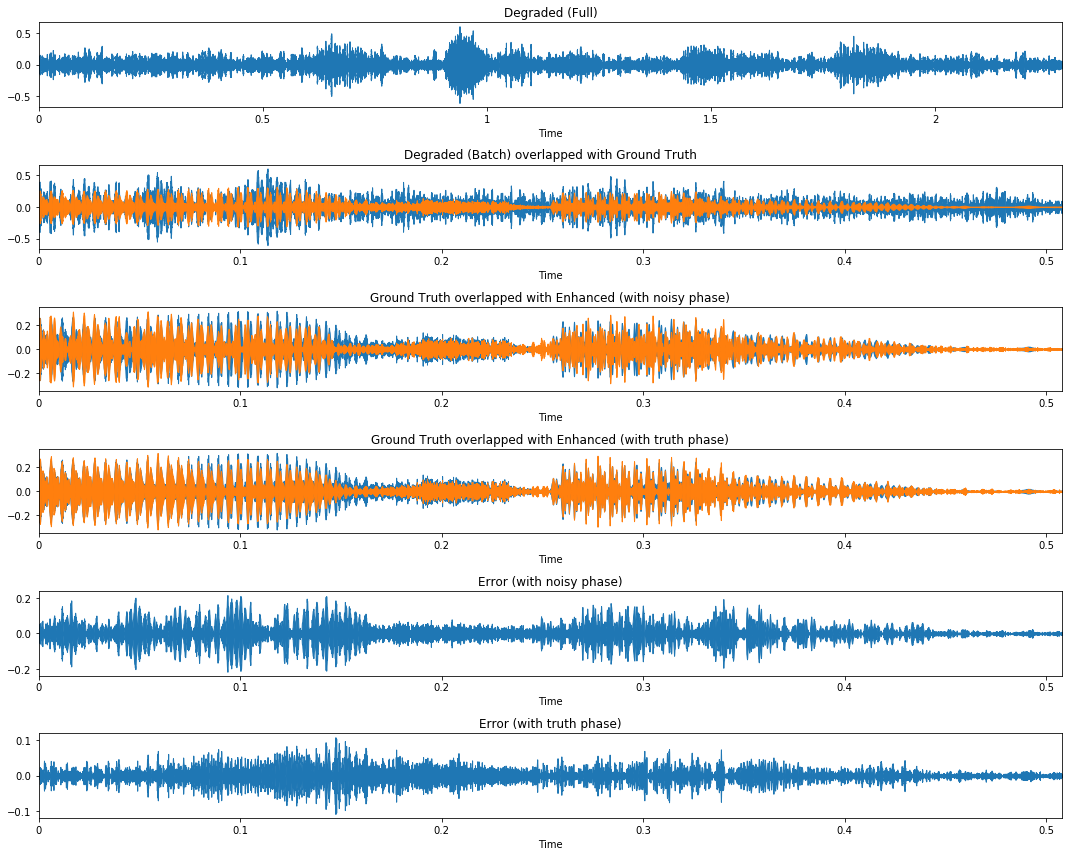

In [116]:
overlap_with = 'not_grdtruth' # 'grdtruth'
## Waveform Plots
plt.figure(figsize=(15,12))
k=6;col=1;l=1; colorbar=None
plt.subplot(k,col,l); l+=1; display_audio(x1, 'Degraded (Full)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(x_istft, None, sr, 'wave'); display_audio(y_istft, 'Degraded (Batch) overlapped with Ground Truth', sr, 'wave')
if overlap_with == 'grdtruth':
    plt.subplot(k,col,l); l+=1; display_audio(x_istft_1, None, sr, 'wave'); display_audio(y_istft, 'Enhanced (with noisy phase) overlapped with Ground Truth', sr, 'wave')
    plt.subplot(k,col,l); l+=1; display_audio(x_istft_2, None, sr, 'wave'); display_audio(y_istft, 'Enhanced (with truth phase) overlapped with Ground Truth', sr, 'wave')
else:
    # plt.subplot(k,col,l); l+=1; display_audio(y_istft, 'Ground Truth', sr, 'wave'); display_audio(x_istft, 'Degraded (Batch)', sr, 'wave')
    plt.subplot(k,col,l); l+=1; display_audio(y_istft, None, sr, 'wave'); display_audio(x_istft_1, 'Ground Truth overlapped with Enhanced (with noisy phase)', sr, 'wave')
    plt.subplot(k,col,l); l+=1; display_audio(y_istft, None, sr, 'wave'); display_audio(x_istft_2, 'Ground Truth overlapped with Enhanced (with truth phase)', sr, 'wave')

plt.subplot(k,col,l); l+=1; display_audio(np.abs(x_istft_1-y_istft), 'Error (with noisy phase)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(np.abs(x_istft_2-y_istft), 'Error (with truth phase)', sr, 'wave')
plt.tight_layout()

# Prediction & Analysis on full region

In [152]:
save_or_load = 'load'

model_path = Weights_path+Archi_dir[:-1]+"_model_v1_1.json"; weights_path = Weights_path+Archi_dir[:-1]+"_weights_v1_1.h5"

# model_path = Weights_path+Archi_dir[:-1]+"_model_v1_2.json"; weights_path = Weights_path+Archi_dir[:-1]+"_weights_v1_2.h5"

if save_or_load == 'save':
    save_model(train_model_v1_2, model_path, weights_path)
elif save_or_load == 'load':
    loaded_model = load_model(model_path, 'path', weights_path, 'final')
    loaded_model.summary()

Loaded model from path : v1/Logs/v1_model_v1_1.json
Loaded weights         : v1/Logs/v1_weights_v1_1.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 129, 128, 1)       0         
_________________________________________________________________
Conv_SubNet (Model)          (None, 129, 128, 1)       56657     
_________________________________________________________________
reshape_17 (Reshape)         (None, 129, 128)          0         
_________________________________________________________________
permute_17 (Permute)         (None, 128, 129)          0         
_________________________________________________________________
Bi_RNN_SubNet (Model)        (None, 128, 129)          350622    
_________________________________________________________________
permute_18 (Permute)         (None, 129, 128)          0         
______________________________________

In [153]:
num_freq,x1_mag.shape[1],num_channel

(129, 375, 1)

In [154]:
time_step_longer = x1_mag.shape[1]

Inp1 = Input(shape=(num_freq,time_step_longer,num_channel), name="Input")
conv_subnet = loaded_model.get_layer('Conv_SubNet')
model_long_1 = Model(Inp1,conv_subnet(Inp1))
model_long_1.summary()
# print('\nLoaded conv_subnet\n')

Inp2 = Input(shape=(time_step_longer,num_freq), name="Input")
rnn_subnet = loaded_model.get_layer('Bi_RNN_SubNet')
model_long_2 = Model(Inp2,rnn_subnet(Inp2))
model_long_2.summary()
# print('\nLoaded rnn_subnet\n')

########################### Architecture (Long) ########################
Inp = Input(shape=(num_freq, time_step_longer, 1), name="Input")
conv_sub = model_long_1(Inp)
x = Reshape((num_freq,time_step_longer))(conv_sub)
x = Permute((2,1))(x)
rnn_sub = model_long_2(x)
x = Permute((2,1))(rnn_sub)
x = Reshape((num_freq,time_step_longer,1))(x)
########################### Printing information ########################
FULL_Spec_model = Model(Inp,x)
FULL_Spec_model.summary()
# print_model_weights(model_longer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 129, 375, 1)       0         
_________________________________________________________________
Conv_SubNet (Model)          multiple                  56657     
Total params: 56,657
Trainable params: 56,657
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 375, 129)          0         
_________________________________________________________________
Bi_RNN_SubNet (Model)        multiple                  350622    
Total params: 350,622
Trainable params: 350,622
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________


In [164]:
## Enhancement of spectrogram
y_hat_mag = FULL_Spec_model.predict(x1_mag.reshape(1, num_freq, time_step_longer, 1))[0,:,:,0]
print('y_hat_mag    ', y_hat_mag.shape)

## Convert to wav file
x_istft       = spect2wav(None, x1_mag,    x1_pha, [None,None], mode='Spect')
y_hat_istft_1 = spect2wav(None, y_hat_mag, x1_pha, [None,None], mode='Spect')
y_hat_istft_2 = spect2wav(None, y_hat_mag, x2_pha, [None,None], mode='Spect')
y_istft       = spect2wav(None, x2_mag,    x2_pha, [None,None], mode='Spect')
print('x_istft      ',x_istft.shape)
print('y_hat_istft_1',y_hat_istft_1.shape)
print('y_hat_istft_2',y_hat_istft_2.shape)
print('y_istft      ',y_istft.shape)

y_hat_mag     (129, 375)
x_istft       (23936,)
y_hat_istft_1 (23936,)
y_hat_istft_2 (23936,)
y_istft       (23936,)


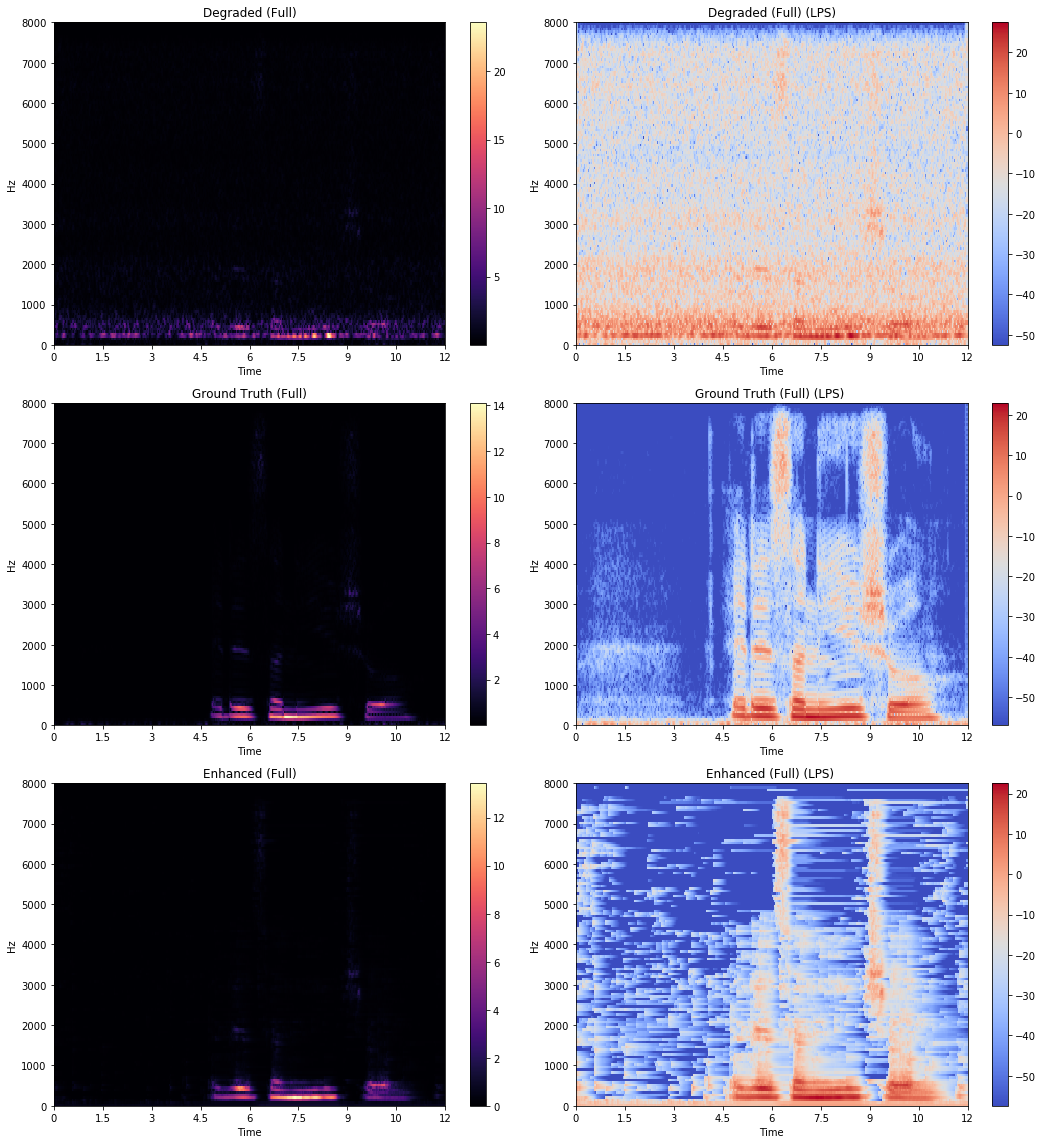

In [156]:
## Spectrogram plots
plt.figure(figsize=(15,16))
k=3;col=2;l=1; colorbar=1 #None
plt.subplot(k,col,l); l+=1; display_audio(x1_mag, 'Degraded (Full)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(librosa.amplitude_to_db(x1_mag), 'Degraded (Full) (LPS)', sr, 'spec', colorbar=colorbar)

plt.subplot(k,col,l); l+=1; display_audio(x2_mag, 'Ground Truth (Full)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(librosa.amplitude_to_db(x2_mag), 'Ground Truth (Full) (LPS) ', sr, 'spec', colorbar=colorbar)

plt.subplot(k,col,l); l+=1; display_audio(y_hat_mag, 'Enhanced (Full)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(librosa.amplitude_to_db(y_hat_mag), 'Enhanced (Full) (LPS) ', sr, 'spec', colorbar=colorbar)
plt.tight_layout()

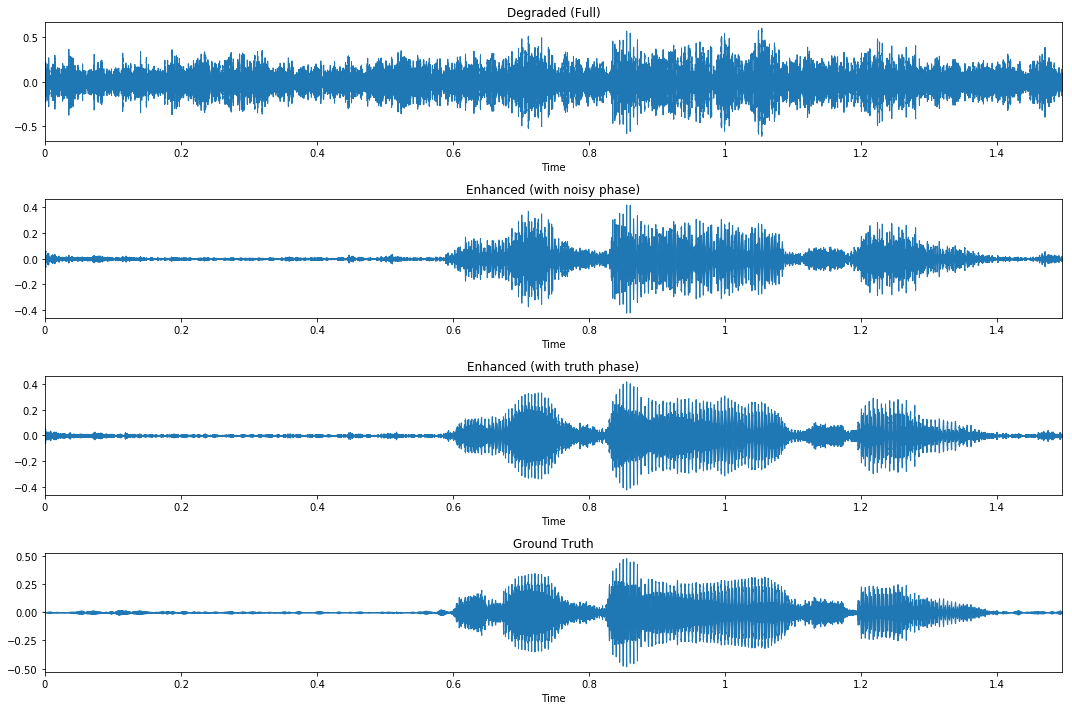

In [165]:
## Waveform Plots
plt.figure(figsize=(15,12))
k=5;col=1;l=1; colorbar=None
plt.subplot(k,col,l); l+=1; display_audio(x_istft, 'Degraded (Full)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(y_hat_istft_1, 'Enhanced (with noisy phase)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(y_hat_istft_2, 'Enhanced (with truth phase)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(y_istft, 'Ground Truth', sr, 'wave')
plt.tight_layout()

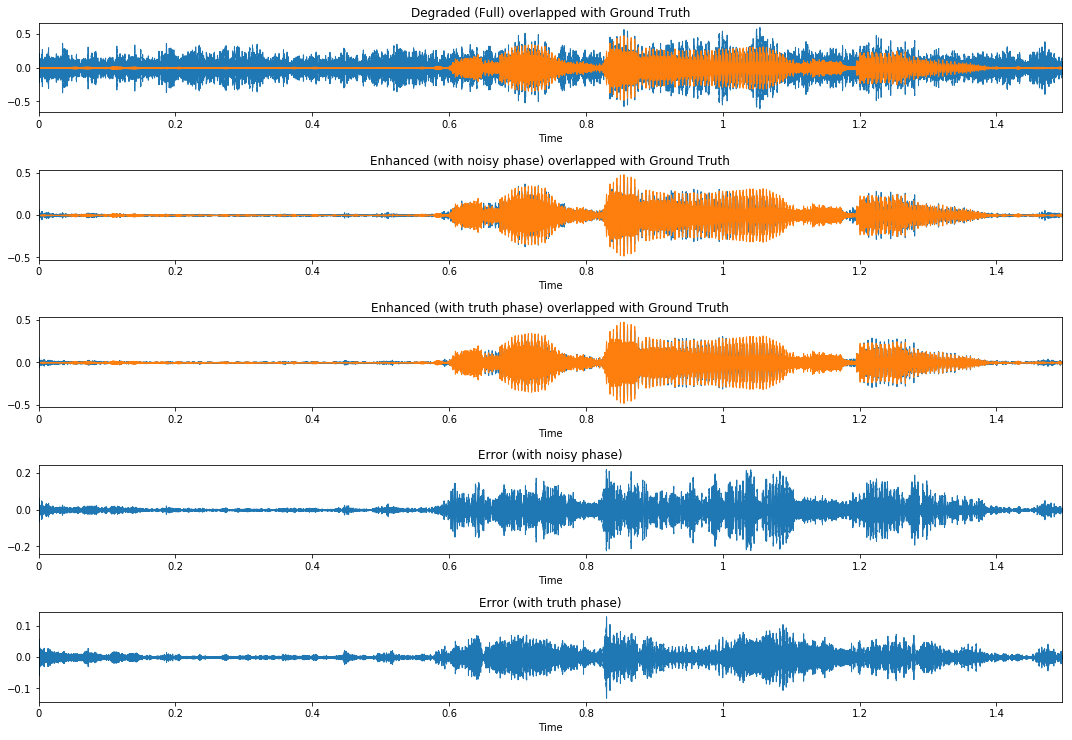

In [169]:
overlap_with = 'grdtruth' # 'grdtruth' 'not_grdtruth'
## Waveform Plots
plt.figure(figsize=(15,12))
k=6;col=1;l=1; colorbar=None
plt.subplot(k,col,l); l+=1; display_audio(x_istft, None, sr, 'wave'); display_audio(y_istft, 'Degraded (Full) overlapped with Ground Truth', sr, 'wave')
if overlap_with == 'grdtruth':
    plt.subplot(k,col,l); l+=1; display_audio(y_hat_istft_1, None, sr, 'wave'); display_audio(y_istft, 'Enhanced (with noisy phase) overlapped with Ground Truth', sr, 'wave')
    plt.subplot(k,col,l); l+=1; display_audio(y_hat_istft_2, None, sr, 'wave'); display_audio(y_istft, 'Enhanced (with truth phase) overlapped with Ground Truth', sr, 'wave')
else:
    # plt.subplot(k,col,l); l+=1; display_audio(y_istft, 'Ground Truth', sr, 'wave'); display_audio(x_istft, 'Degraded (Batch)', sr, 'wave')
    plt.subplot(k,col,l); l+=1; display_audio(y_istft, None, sr, 'wave'); display_audio(y_hat_istft_1, 'Ground Truth overlapped with Enhanced (with noisy phase)', sr, 'wave')
    plt.subplot(k,col,l); l+=1; display_audio(y_istft, None, sr, 'wave'); display_audio(y_hat_istft_2, 'Ground Truth overlapped with Enhanced (with truth phase)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(np.abs(y_hat_istft_1-y_istft), 'Error (with noisy phase)', sr, 'wave')
plt.subplot(k,col,l); l+=1; display_audio(np.abs(y_hat_istft_2-y_istft), 'Error (with truth phase)', sr, 'wave')
plt.tight_layout()

In [170]:
print('## Input (Full)'); display_audio(x_istft, None, sr, 'audio')
print('## Enhanced (with noisy phase)'); display_audio(y_hat_istft_1, None, sr, 'audio')
print('## Enhanced (with truth phase)'); display_audio(y_hat_istft_2, None, sr, 'audio')
print('## Ground Truth'); display_audio(y_istft, None, sr, 'audio')

## Input (Full)


## Enhanced (with noisy phase)


## Enhanced (with truth phase)


## Ground Truth


## Phase Plots seem rather random, but has several horizontal streaks. 
## Worth investigating learning phase in v2 ?

##### Viewing by librosa

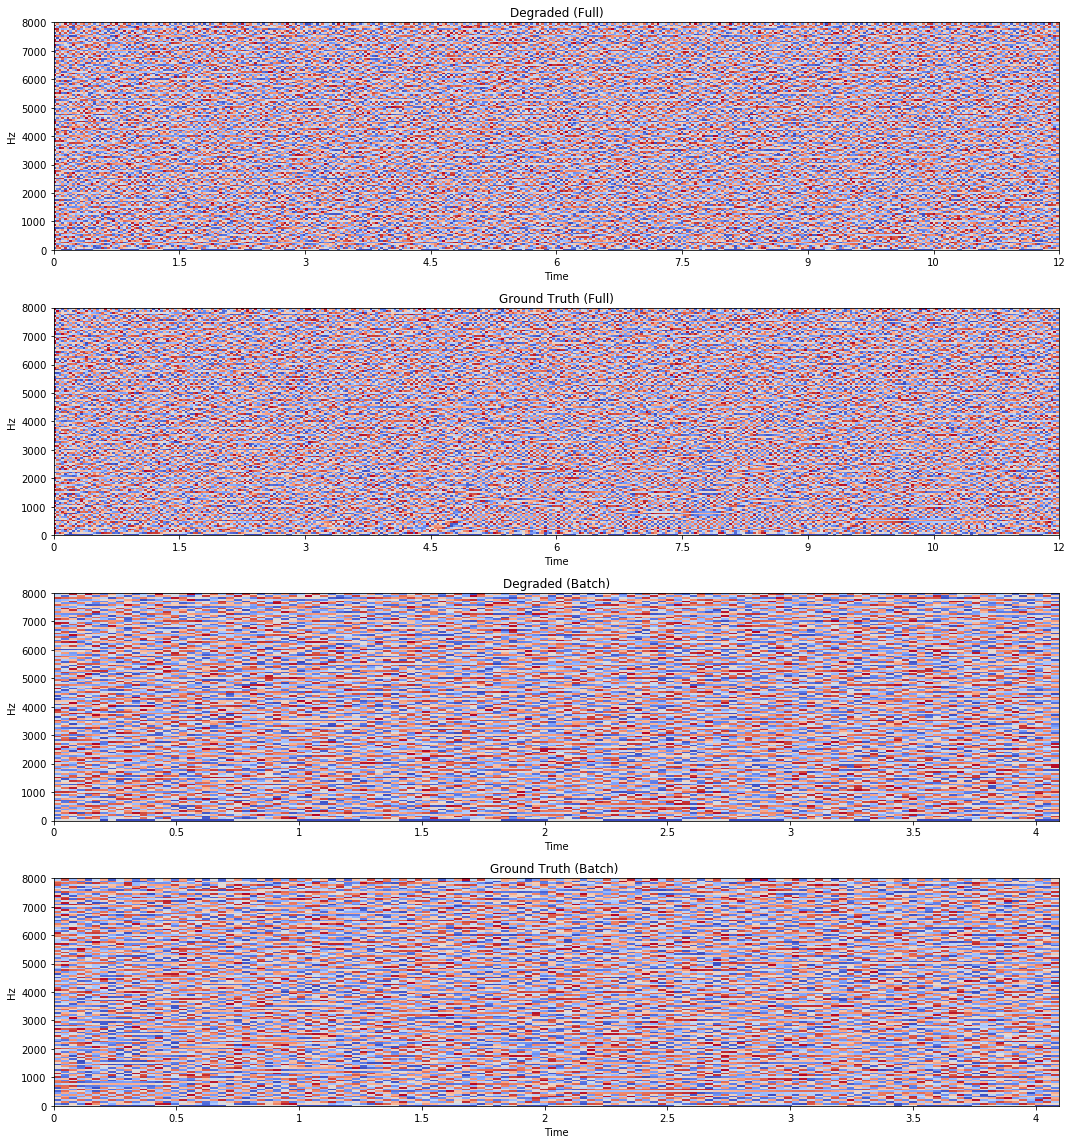

In [119]:
## Phase plots
plt.figure(figsize=(15,16))
k=4;col=1;l=1; colorbar=None
plt.subplot(k,col,l); l+=1; display_audio(x1_pha, 'Degraded (Full)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(x2_pha, 'Ground Truth (Full)', sr, 'spec', colorbar=colorbar)

plt.subplot(k,col,l); l+=1; display_audio(x_batch_pha, 'Degraded (Batch)', sr, 'spec', colorbar=colorbar)
plt.subplot(k,col,l); l+=1; display_audio(y_batch_pha, 'Ground Truth (Batch) ', sr, 'spec', colorbar=colorbar)
plt.tight_layout()

##### Viewing by matplotlib

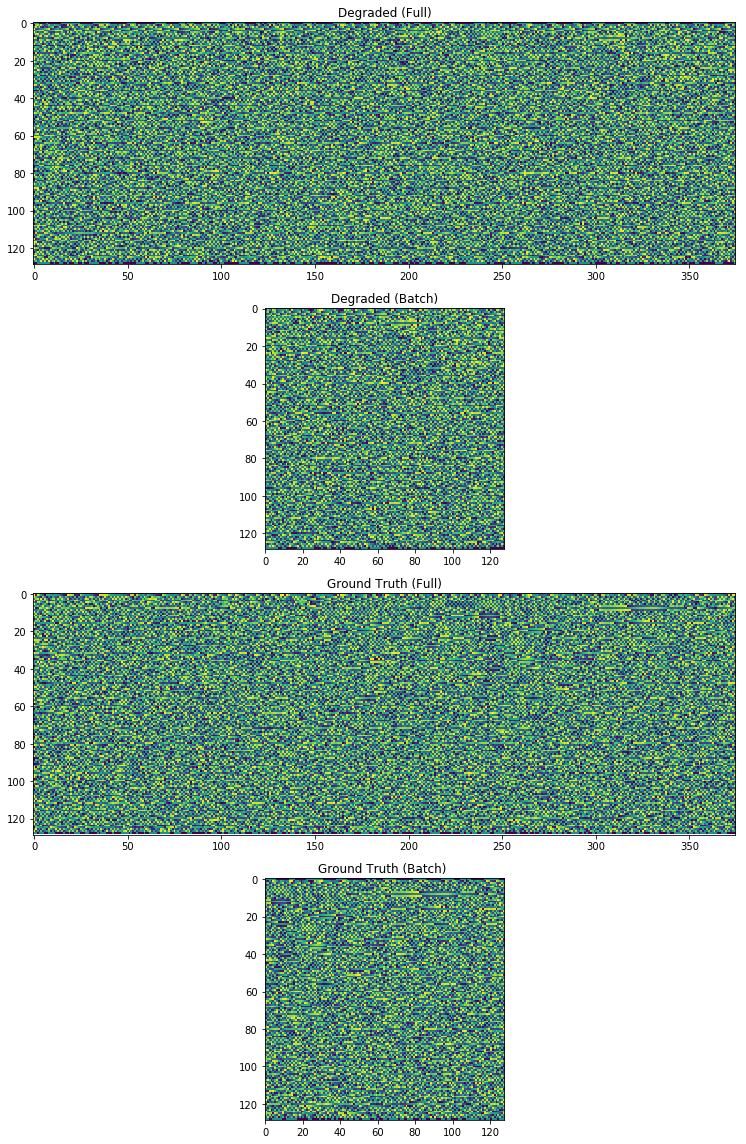

In [122]:
## Phase plots
plt.figure(figsize=(18,16))
k=4;col=1;l=1; colorbar=1 #None
plt.subplot(k,col,l); l+=1; plt.imshow(x1_pha); 
plt.title('Degraded (Full)')
plt.subplot(k,col,l); l+=1; plt.imshow(x_batch_pha); 
plt.title('Degraded (Batch)')
plt.subplot(k,col,l); l+=1; plt.imshow(x2_pha); 
plt.title('Ground Truth (Full)')
plt.subplot(k,col,l); l+=1; plt.imshow(y_batch_pha); 
plt.title('Ground Truth (Batch) ')
plt.tight_layout()